Dursun Dashdamirov.

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

from sklearn.utils import estimator_html_repr
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from pipelinehelper import PipelineHelper
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


In [2]:
import missingno
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


from pipelinehelper import PipelineHelper
from IPython.display import Image
from IPython.core.display import HTML 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import f1_score
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest, f_regression

## Loading data

In [3]:
data = pd.read_csv("Credit Risk.csv")

In [4]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [6]:
data.describe() #describing simple statistics for numerical columns

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


The "Credit_History" column seems suspicious, let's check data types:

In [7]:
data.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

It has format of float but in reality that column indicates availibility of previous credit history. So we can just make it categorical variable:

In [8]:
data["Credit_History"] = data["Credit_History"].astype(object)

In [9]:
(data.isnull().sum())/len(data)*100

Loan_ID              0.000000
Gender               2.117264
Married              0.488599
Dependents           2.442997
Education            0.000000
Self_Employed        5.211726
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           3.583062
Loan_Amount_Term     2.280130
Credit_History       8.143322
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64

In [10]:
data2 = data.copy()

The percentages are not that big, so we will be imputing them.

But before that, we have to detect the outliers so that our data will not be affected by outliers.

## Data Cleaning

### Outlier detection 

For this task, I simply defined a function to remove records that are not in inquartile range. Method is simple but yet effective

In [11]:
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_range = Q1 - 1.5*IQR
    upper_range = Q3 + 1.5*IQR
    
    ls = df.index[ (df[col]<lower_range) | (df[col] > upper_range)]
    
    return ls

In [12]:
index_list = []
for feature in ['CoapplicantIncome', 'ApplicantIncome', 'LoanAmount']:
    index_list.extend(remove_outliers(data2, feature))

len(index_list)

107

In [13]:
def remove (df,ls):
    ls = sorted(set(ls))
    df = df.drop(ls)
    return df

In [14]:
data2 = remove(data2, index_list)
data2.shape

(537, 13)

In [15]:
data3 = data2.copy()

### Handling Missing Data

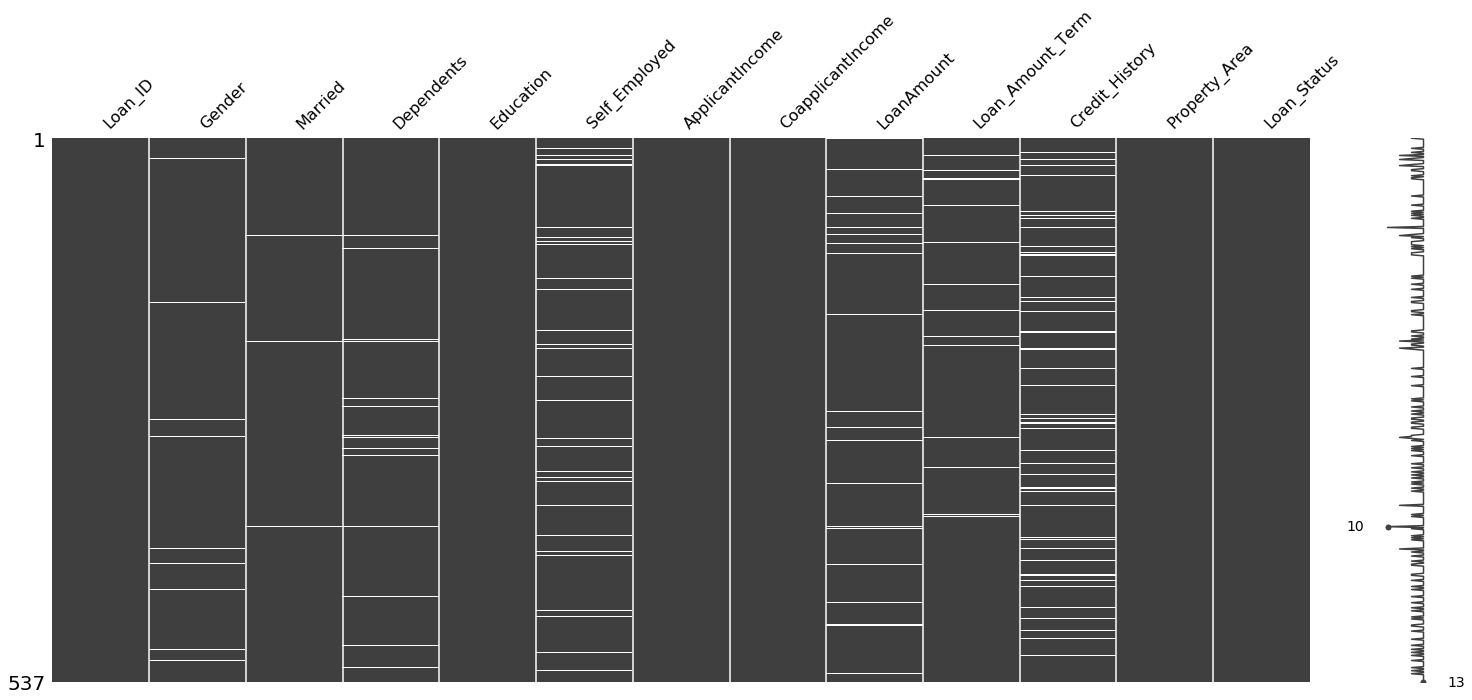

In [16]:
missingno.matrix(data3)

In [17]:
data3.select_dtypes(np.number).loc[:, data3.isna().sum()>0].columns 
#columns which are numerical and have more than 1 null value:

Index(['LoanAmount', 'Loan_Amount_Term'], dtype='object')

In [18]:
# function for KNN imputation
def knn_impute(df, na_target):
    df = df.copy()
    
    numeric_df = df.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[:, numeric_df.isna().sum() == 0].columns
    
    y_train = numeric_df.loc[numeric_df[na_target].isna()==False, na_target]
    X_train = numeric_df.loc[numeric_df[na_target].isna()==False, non_na_columns]
    X_test = numeric_df.loc[numeric_df[na_target].isna()==True, non_na_columns]
    
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    df.loc[df[na_target].isna()==True, na_target] = y_pred
    
    
    return df

In [19]:
for column in ['LoanAmount', 'Loan_Amount_Term']:
       data3 = knn_impute(data3, column)

In [20]:
data3.select_dtypes('object').loc[:, data3.isna().sum()>0].columns

Index(['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History'], dtype='object')

In [21]:
for column in ['Gender', 'Married', 'Dependents', 'Self_Employed','Credit_History']:
    data3[column] = data3[column].fillna(data3[column].mode()[0])    #filling categorical values with mode value

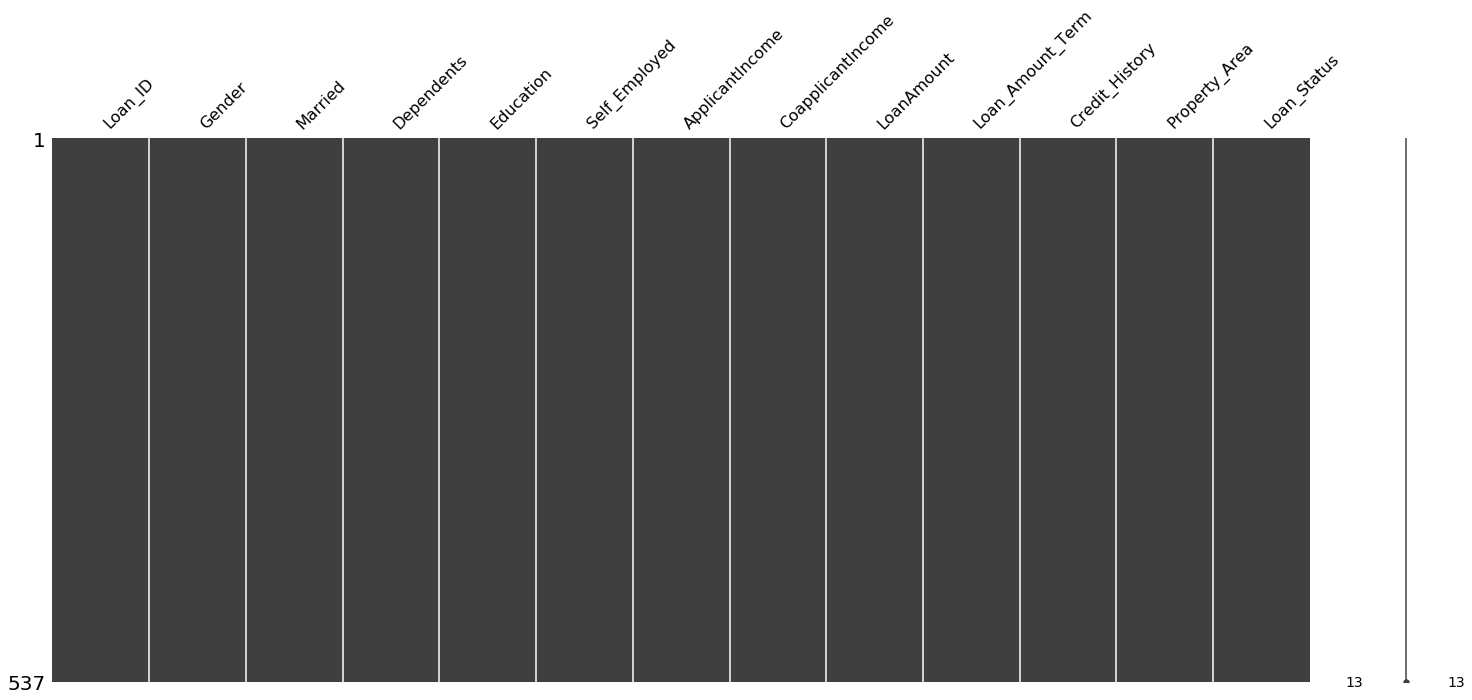

In [22]:
missingno.matrix(data3)

### Cleann!

### Exploratory data analysis

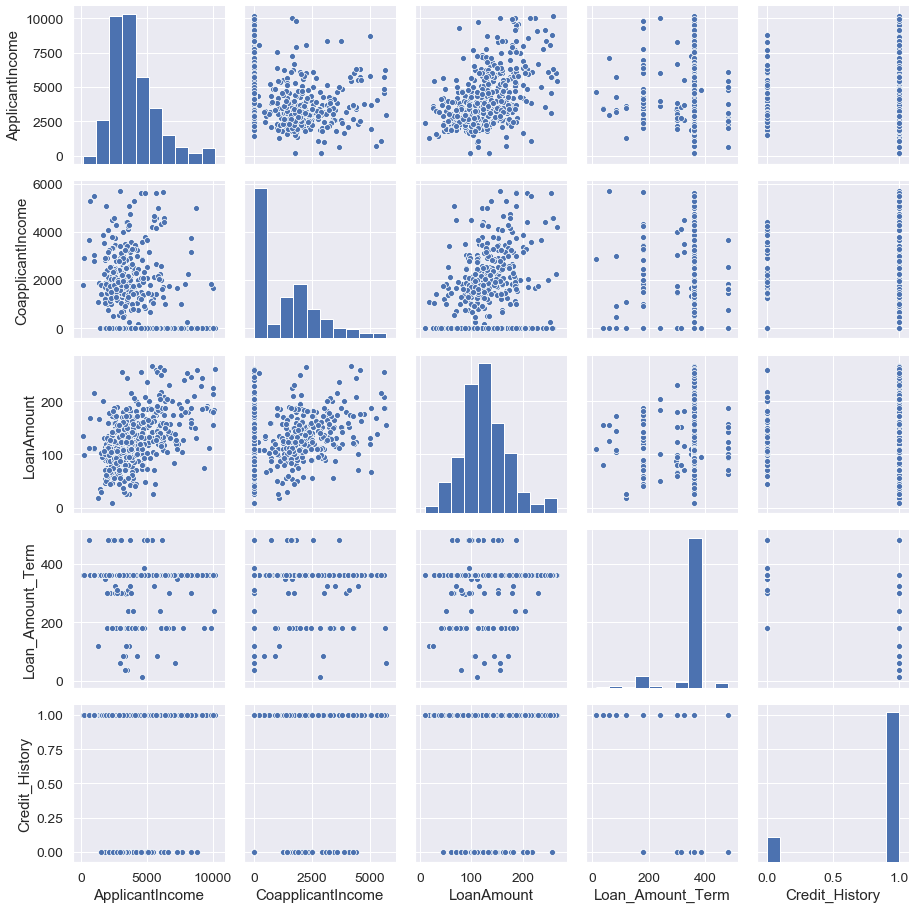

In [83]:
sns.pairplot(data3)

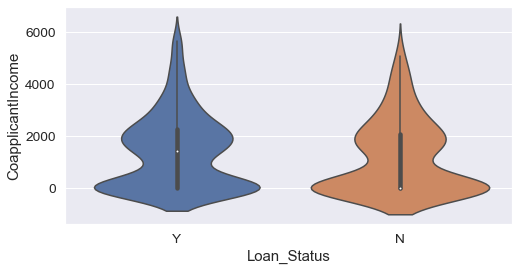

In [105]:
fig, ax = plt.subplots(figsize=(8,4)) 

sns.violinplot(x="Loan_Status", y="CoapplicantIncome", data=data3)

There is not much of difference but it seems if CoapplicantIncome is close to 0, the probability of having the Loan_Status - NO is higher.

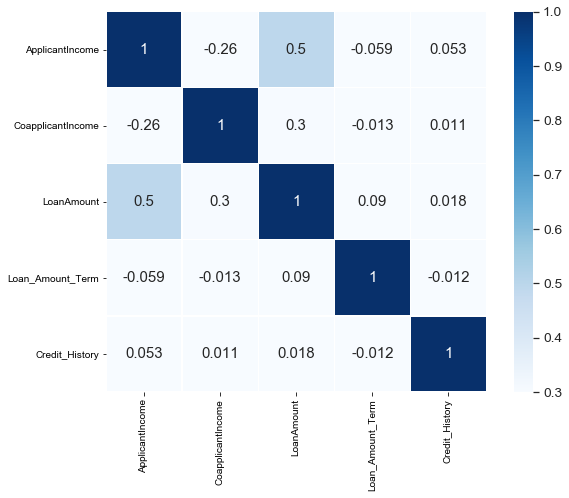

In [24]:
corrmat = data3.corr()
plt.subplots(figsize=(10,7))
sns.set(font_scale=1.25)
sns.heatmap(corrmat, vmax=1,vmin=0.3, cmap="Blues",annot=True, square=True, linewidths=.2)

### Quick check of how variables are sperated in spesific classes:

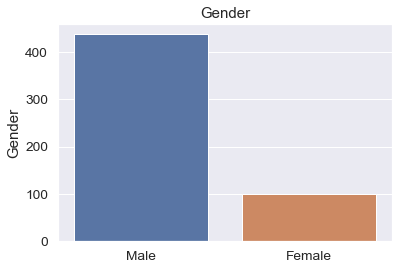

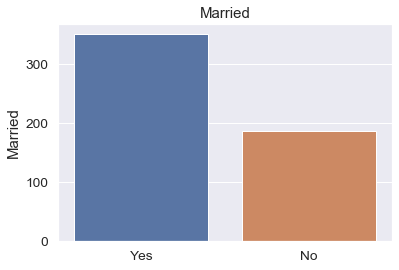

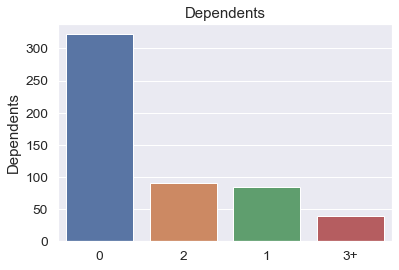

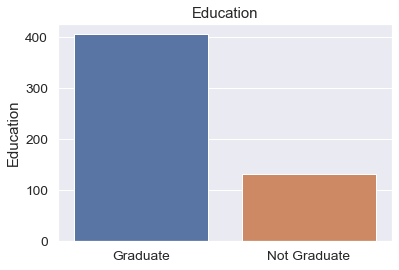

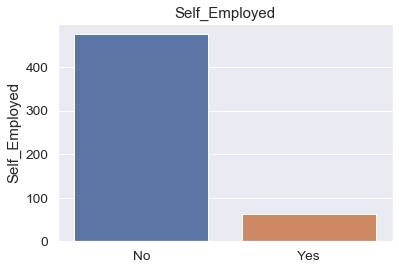

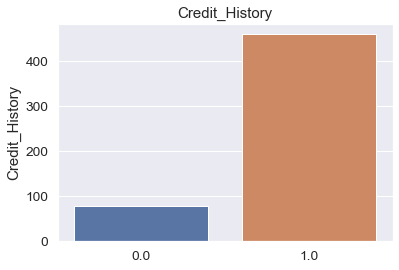

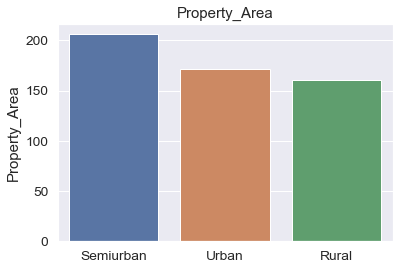

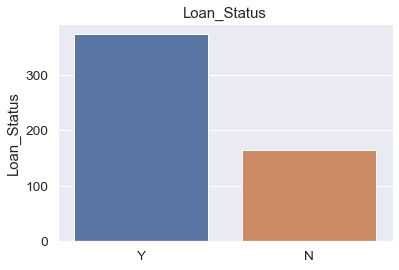

In [25]:
categorical = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed','Credit_History','Property_Area', 'Loan_Status']
for i in data3.columns:
    if i in categorical:
        
        sns.barplot(data3[i].value_counts().index,data3[i].value_counts()).set_title(i)
        plt.show()

### Let's do some boxplots to see distribution of numerical values:

The left plot indicates the distribution before outlier removal, and right one after removal.

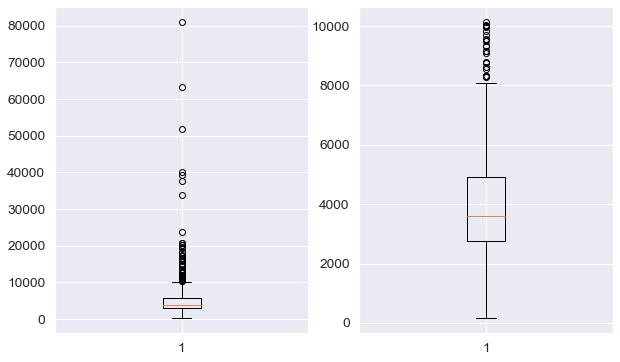

In [26]:
fig, ax = plt.subplots(1,2, figsize=(10,6)) 
ax[0].boxplot('ApplicantIncome', data=data)
ax[1].boxplot('ApplicantIncome', data=data2)


plt.show()

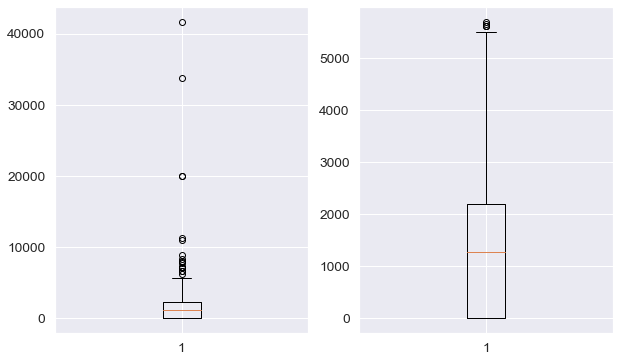

In [27]:
fig, ax = plt.subplots(1,2, figsize=(10,6)) 
ax[0].boxplot('CoapplicantIncome', data=data)
ax[1].boxplot('CoapplicantIncome', data=data2)


plt.show()

In [28]:
data4 = data3.copy()

### Continuing with encoding the data:

In [29]:
data5 = data4.copy()

In [30]:
# Label Encoding the target variable
label_encoder = LabelEncoder().fit(data5[['Loan_Status']])
data5[['Loan_Status']] = label_encoder.transform( data5[['Loan_Status']])

In [31]:
data5 = pd.get_dummies(data5, columns=['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed','Credit_History','Property_Area'])

In [32]:
data5.head(7)

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Gender_Female,Gender_Male,Married_No,Married_Yes,...,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Credit_History_0.0,Credit_History_1.0,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,LP001002,5849,0.0,147.8,360.0,1,0,1,1,0,...,0,1,0,1,0,0,1,0,0,1
1,LP001003,4583,1508.0,128.0,360.0,0,0,1,0,1,...,0,1,0,1,0,0,1,1,0,0
2,LP001005,3000,0.0,66.0,360.0,1,0,1,0,1,...,0,1,0,0,1,0,1,0,0,1
3,LP001006,2583,2358.0,120.0,360.0,1,0,1,0,1,...,0,0,1,1,0,0,1,0,0,1
4,LP001008,6000,0.0,141.0,360.0,1,0,1,1,0,...,0,1,0,1,0,0,1,0,0,1
5,LP001011,5417,4196.0,267.0,360.0,1,0,1,0,1,...,0,1,0,0,1,0,1,0,0,1
6,LP001013,2333,1516.0,95.0,360.0,1,0,1,0,1,...,0,0,1,1,0,0,1,0,0,1


## Scaling

In [33]:
 from sklearn.preprocessing import StandardScaler

In [34]:
col_names = ["ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term"]
features = data5[col_names]

#Standard scaler is used
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

data5[col_names] = features

In [35]:
data5.head(3)

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Gender_Female,Gender_Male,Married_No,Married_Yes,...,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Credit_History_0.0,Credit_History_1.0,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,LP001002,0.966502,-0.934424,0.461693,0.272677,1,0,1,1,0,...,0,1,0,1,0,0,1,0,0,1
1,LP001003,0.282556,0.125168,0.028419,0.272677,0,0,1,0,1,...,0,1,0,1,0,0,1,1,0,0
2,LP001005,-0.572646,-0.934424,-1.328298,0.272677,1,0,1,0,1,...,0,1,0,0,1,0,1,0,0,1


## Hyperparameter Optimization

Before passing to regular train_test_split and predictions, I will be testing different hyperparameters with various classification algorithms to find best model and best hyperparameters of that model.

In [36]:
X = data5.drop(['Loan_ID','Loan_Status'], axis=1)
y = data5[['Loan_Status']]

In [38]:
# Simple Pipeline for GridSerach
model_pipeline2=Pipeline(steps=[
    ('classifier', PipelineHelper([
        
        ('nn', KNeighborsClassifier()),
        ('lr', LogisticRegression()),
        ('gnb', GaussianNB()),
        ('dt', tree.DecisionTreeClassifier()),
        ('rf', RandomForestClassifier())
    ])), 
])

In [81]:
params = {
    'classifier__selected_model': model_pipeline2.named_steps['classifier'].generate({
        'nn__n_neighbors':[6,7,8,9,10,11,12,13,14,15],
        'nn__weights':['uniform', 'distance'],
        
        'lr__penalty': ['none','l1','l2','elasticnet'],
        'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'gnb__var_smoothing': [1e-11, 1e-10, 1e-9],
        'dt__max_depth': [3,4,5,6,7,8,9,10]
        })
}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# GridSearch is also doing cross-validation of data, but we can also add kfold
grid = GridSearchCV(model_pipeline2, params, cv=kfold, scoring='accuracy')
result = grid.fit(X,y)
print('Best Score: ',  round((result.best_score_),4))
print('--------------------------------')
print (result.best_params_)

Best Score:  0.823
--------------------------------
{'classifier__selected_model': ('gnb', {'var_smoothing': 1e-11})}


It is important to note that, we have to be careful with GridSearchCV. Giving the whole data to find best parameters, all data is being used by algorithm and  we dont really have unseen test data. In our case, data is not that big, so instead of splitting it, for prediction I have redefined the GaussianNB algorithm as gnb and did train_test_split and final accuracy tests on our new seperate algorithm.

## Prediction 

In [70]:
gnb = GaussianNB(var_smoothing= 1e-11)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape, y_train.shape)

(359, 21) (359, 1)


In [72]:
gnb.fit(X_train,y_train)

GaussianNB(var_smoothing=1e-11)

In [73]:
y_pred = gnb.predict(X_test)

In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.51      0.66        51
           1       0.83      0.98      0.90       127

    accuracy                           0.85       178
   macro avg       0.88      0.75      0.78       178
weighted avg       0.86      0.85      0.83       178



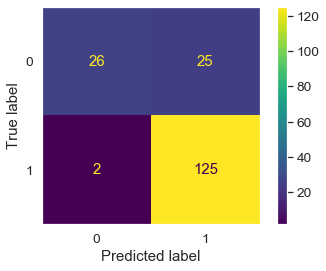

In [75]:
plot_confusion_matrix(gnb, X_test, y_test)
plt.grid(False)


### Coming to the model's performance,
Prediction of non-problematic customers ("Yes" label, we are giving loan to them) has pretty high recall value (around 98%) but in the case of problematic ("No" label), we were not enough selective about customers. Also I have tried feature selection but deviation was too small and I have decided to use all of features. Overall, having 85% accuracy, we can say that our model did good job but further Feature Enginnering must be conducted in order to get higher recall value in 0 label. 